# Text-network Visualization and Analysis

This work is based upon:
(https://gitlab.com/mattiasostmar/discoursebias/blob/master/README.md)

And in the reference article cited in the same README.

Its only a draft, but it's intended to give birth to articles about the content public available of text with the same topics such Buddhism (my aim).

Thus any subsequential working related to these will have it's own place/repository. 

Hope you enjoy this for awhile.

In [1]:
import tnread as did
import nltk
import plotly.graph_objects as go
%matplotlib inline

#nltk.download('stopwords')
#nltk.download('rslp')

# Run on text from file

First we load a file and read it's contents

In [ ]:
# Blazing Resplendor
file = open("texts/pt/tulkutest.txt")
name = file.name
text = file.read()

In [2]:
# Otavio conto um
file = open("texts/pt/um_otavio.txt")
name = file.name
text = file.read()

In [ ]:
# Otavio conto dois
file = open("texts/pt/dois_otavio.txt")
name = file.name
text = file.read()

In [ ]:
# random text
file = open("magic_happiness.txt")
name = file.name
text = file.read()

In [ ]:
# Tantra Part 1.0

text = " Identificando o Criador de Todos os Fenômenos como Sendo a Mente Examine o corpo, a fala e a mente e reconheça qual é o primordial como o monarca que tudo cria. Aqui está a maneira de examinar o agente, ou o monarca, que cria todos os fenômenos como sendo a mente, que é primordial entre o corpo, a fala e a mente. Durante o dia, a noite e o período intermediário, devido à autofixação da mente, o corpo e a fala surgem para a mente. Ao longo da vida é a mente que experimenta alegria e tristeza. Ao final, quando o corpo e a mente se separam, o corpo é deixado para trás como um cadáver. Quando a fala desaparece sem deixar vestígios, a mente segue o carma e é o agente que vagueia no saṃsāra. De uma perspectiva, por essas três razões, reconheça aquilo que é primordial como sendo a mente. De outra perspectiva, nenhum desses três é outra coisa além da mente, portanto, ao determiná-los como sendo apenas a mente, reconheça aquilo que é primordial como sendo a mente. A primeira perspectiva é determinada de acordo com o modo convencional das aparências, enquanto a última perspectiva é determinada de acordo com o modo convencional da existência. Para explicar um pouco mais o significado dessa última perspectiva, o tratado do Mahāpaṇḍita Nāropā, A Síntese da Visão, afirma: O Tantra do Vajra Cortante – parte 1  Lama Alan Wallace – Retiro \n Todos os fenômenos que surgem e passam a existir não têm existência separada da mente autoconsciente, pois esta faz com que surjam e fiquem claros, assim como a experiência da própria lucidez. Se eles não fossem a mente, não teriam relação com a mente e nem mesmo surgiriam. Determine a realidade enganosa13 dessa maneira.14 Para a mente deludida, o corpo e a mente surgem como se fossem diferentes, mas em termos de seu modo de existência, eles se apresentam diretamente à consciência não conceitual e são claramente experienciados. Isso indica que eles existem não como algo material, mas simplesmente como a iluminação natural da própria consciência, como a consciência que experiencia alegria e tristeza. Se eles não fossem a mente, mas fossem matéria, como luz e escuridão, nunca poderiam interagir com a mente e, portanto, nunca poderiam surgir. Por essas razões, o corpo e a fala – na verdade todos os fenômenos aparentes – são estabelecidos como sendo a mente."
name = "Tantra Vajra Cortante"

Then create a discoursebias Text object, sending in the text and the name of the file as identifier for later use.

In [3]:
experiment = did.TextNetwork(text, name, stemmer="porter", stem=False, max_nodes=100, window = 10, plot=False, lang="pt")

In [4]:
data = experiment.run()

texts/pt/um_otavio.txt bias index: FOCUSED
Stored graph as um_otavio.graphml in /home/penalvad/Desktop/textnet-read/tnread/gexf/.


Now we can look at the data in the returned DataFrame.

Communities plotting

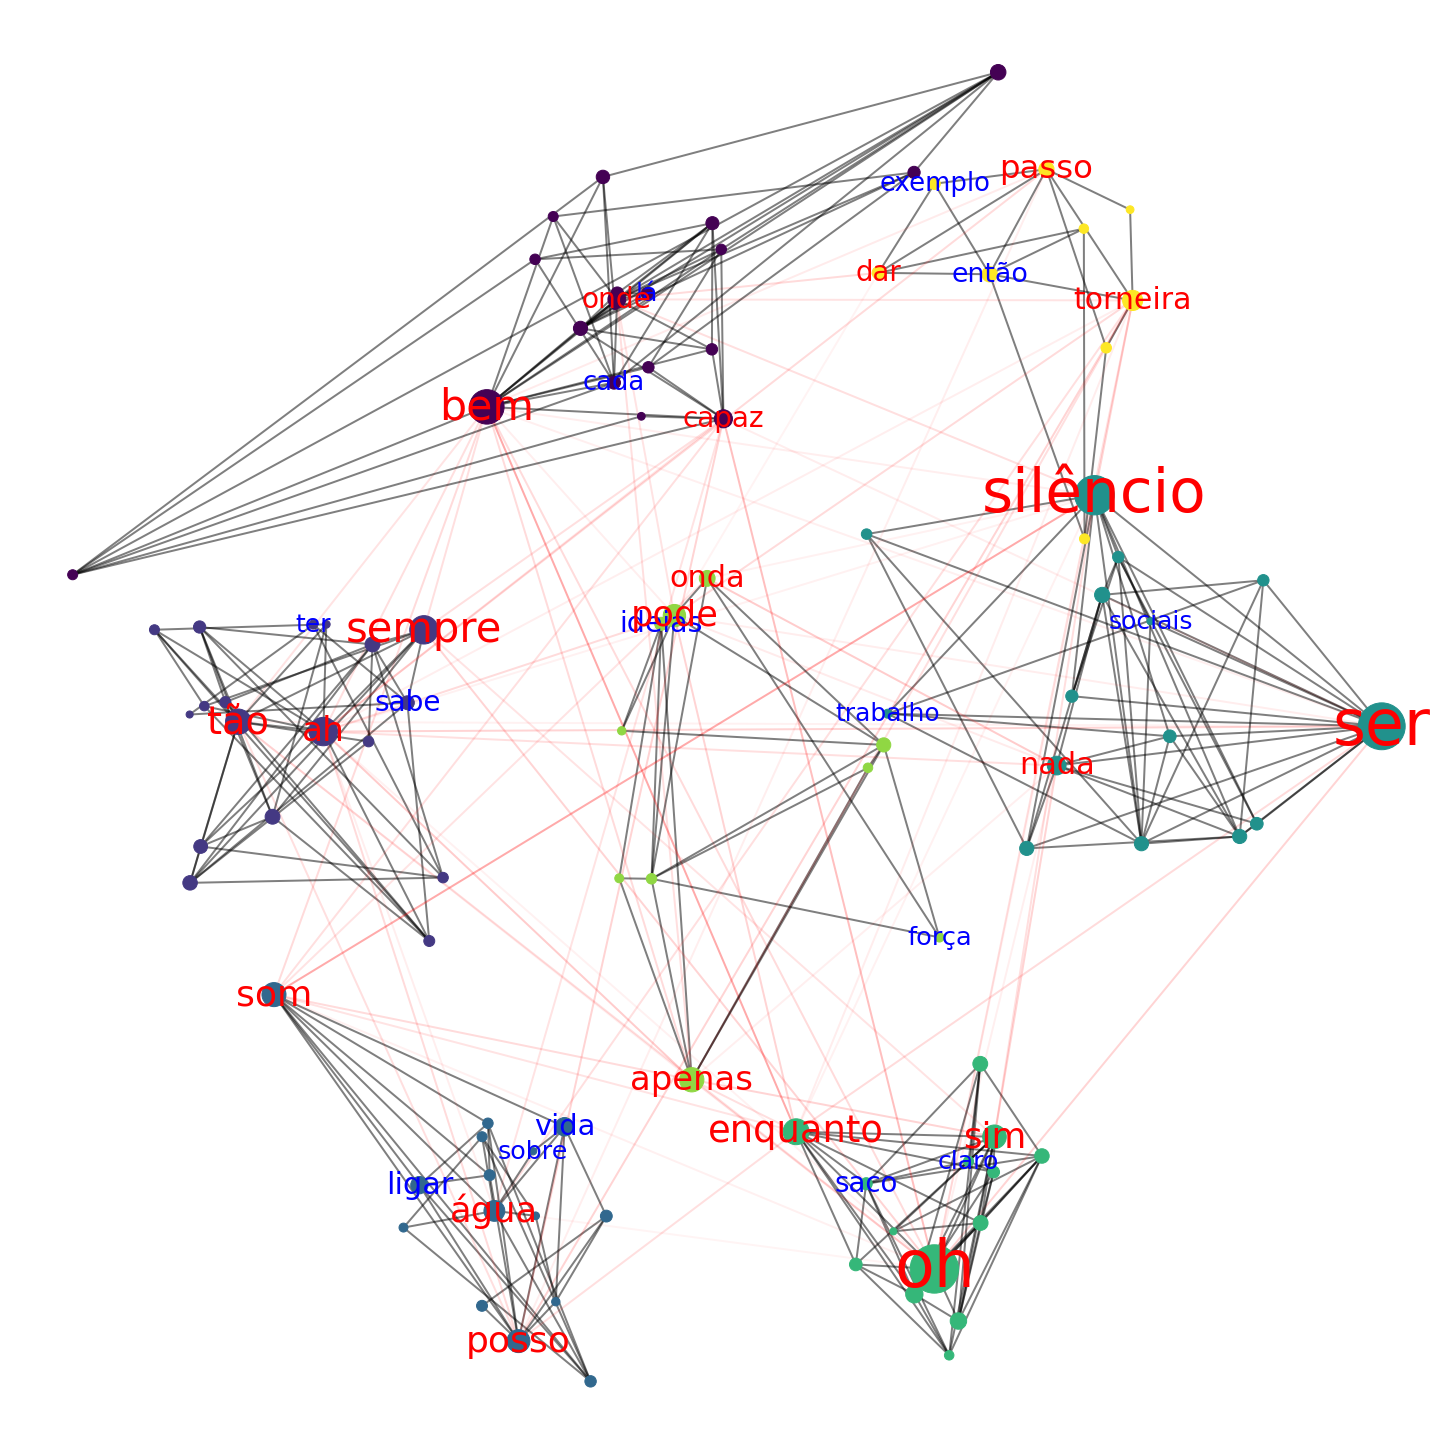

In [5]:
vis=did.TextnetVis(experiment)
vis.plot_textnet()

In [6]:
list(vis.textnet.finalGraph.edges.data())

[('ter',
  'meio',
  {'weight': 0.14285714285714285, 'roles': ['hub', 'community intern']}),
 ('ter', 'sabe', {'weight': 0.125, 'roles': ['hub', 'community intern']}),
 ('ter',
  'vida',
  {'weight': 0.16666666666666666, 'roles': ['hub', 'inter communities']}),
 ('ter', 'pessoa', {'weight': 0.25, 'roles': ['hub', 'inter communities']}),
 ('ter', 'dar', {'weight': 0.14285714285714285, 'roles': ['hub', 'diffusor']}),
 ('ter',
  'desde',
  {'weight': 0.14285714285714285, 'roles': ['hub', 'community intern']}),
 ('ter', 'momento', {'weight': 0.125, 'roles': ['hub', 'inter communities']}),
 ('ter',
  'entende',
  {'weight': 0.14285714285714285, 'roles': ['hub', 'inter communities']}),
 ('ligar', 'sempre', {'weight': 0.25, 'roles': ['hub', 'diffusor']}),
 ('ligar',
  'música',
  {'weight': 0.1111111111111111, 'roles': ['hub', 'inter communities']}),
 ('ligar', 'antes', {'weight': 0.125, 'roles': ['hub', 'inter communities']}),
 ('ligar',
  'torneira',
  {'weight': 0.16666666666666666, 'roles

# Plotly Vis (dev)

In [ ]:
edge_x = []
edge_y = []
for edge in vis.templatedgraph.edges():
    x0, y0 = vis.pos[edge[0]]
    x1, y1 = vis.pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in vis.templatedgraph.nodes():
    x, y = vis.pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=vis.node_color,
        size=vis.node_size,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [ ]:
vis.node_size=[a*0.05 for a in vis.node_size]

In [ ]:
node_adjacencies = []
node_text = []
names=list(vis.templatedgraph.nodes())
for node, adjacencies in enumerate(vis.templatedgraph.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    nodename=names[node]
    node_text.append(nodename+'\n'+'# of connections: '+str(len(adjacencies[1])))
node_trace.text = node_text

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=experiment.textname,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [ ]:
transposed = data.T # Flip X to Y
results = transposed[["modularity","entropy","nodesInTopCom","nodesInGiantCom"]]
results

# Run on a sequence of texts for comparison

We can run the process of reading several files and adding them into a single Pandas DataFrame for analysis.

In [ ]:
import glob
results_list = []

for pathname in glob.glob('texts/sv/*'): # glob allows regex to be run in the filesystem
    text = open(pathname).read()
    filename = pathname.rpartition("/")[2]
    exp = did.TextNetwork(text, filename, stemmer="porter")
    data = exp.run()
    print("----- new experiment ------")
    
    # Now do a little data munging and add the result data for this file
    transp_results = data.T[["modularity","entropyTopFirst","nodesInTopCom","nodesInGiantCom"]]
    results_list.append(transp_results)

c